## Accessing a STAC catalog of NetCDF files in S3 from Python

In [1]:
%matplotlib inline
from intake_stac import StacCatalog, StacItem
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #make cell display output of all lines


The `intake_stac` module identifies URLs based on starting `https`, so a tiny modification is required to make it accept an http URL (see comment).

First we read in the STAC catalog.  Catalogs can contain additional catalogs, or STAC items.  

In [2]:
#edited line 46 of ~/miniconda3/lib/python3.7/site-packages/satstac/thing.py to 
#allow for non-https url
cat  = StacCatalog('http://dev-owi.usgs.gov/stac-test/catalog.json')
list(cat)

['test_netcdf']

In [3]:
list(cat['test_netcdf'])
cat['test_netcdf']['test_netcdf_big']

['test_netcdf_small', 'test_netcdf_medium', 'test_netcdf_big']

name: test_netcdf_big
container: xarray
plugin: ['netcdf']
description: Big test netcdf file (PR)
direct_access: True
user_parameters: []
metadata: 
  href: http://dev-owi.usgs.gov/stac-test/data/TSK_d02_wrfextr_CNRM.nc
  title: Big test netcdf file (PR)
  type: netcdf
args: 
  urlpath: http://dev-owi.usgs.gov/stac-test/data/TSK_d02_wrfextr_CNRM.nc
  chunks: 

In [4]:
cat['test_netcdf'].metadata

{'datetime': datetime.datetime(2016, 5, 3, 13, 21, 30, 40000, tzinfo=tzutc()),
 'bbox': [-122.59750209, 37.48803556, -122.2880486, 37.613537207],
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.308150179, 37.488035566],
    [-122.597502109, 37.538869539],
    [-122.576687533, 37.613537207],
    [-122.2880486, 37.562818007],
    [-122.308150179, 37.488035566]]]},
 'date': datetime.date(2016, 5, 3),
 'catalog_dir': ''}

In [5]:
cat.items()

dict_items([('test_netcdf', name: test_netcdf
container: catalog
plugin: ['stac-item']
description: 
direct_access: True
user_parameters: []
metadata: 
args: 
  stac_obj: test_netcdf)])

This test catalog contains one STACitem, which contains three assets (files), which are each NetCDF files of varying sizes.

In [6]:
small_asset = cat['test_netcdf']['test_netcdf_small']
medium_asset = cat['test_netcdf']['test_netcdf_medium']
big_asset = cat['test_netcdf']['test_netcdf_big']
big_asset

name: test_netcdf_big
container: xarray
plugin: ['netcdf']
description: Big test netcdf file (PR)
direct_access: True
user_parameters: []
metadata: 
  href: http://dev-owi.usgs.gov/stac-test/data/TSK_d02_wrfextr_CNRM.nc
  title: Big test netcdf file (PR)
  type: netcdf
args: 
  urlpath: http://dev-owi.usgs.gov/stac-test/data/TSK_d02_wrfextr_CNRM.nc
  chunks: 

If this were a local catalog, we could seasmlessly convert the assets to Dask items and start working with the data from there.  However, this fails since the Python NetCDF plugin doesn't handle remote files other than via OPeNDAP.

In [7]:
#errors
big_dask = big_asset.to_dask()

OSError: [Errno -90] NetCDF: file not found: b'http://dev-owi.usgs.gov/stac-test/data/TSK_d02_wrfextr_CNRM.nc'

Since that doesn't work, the best we can for now in Python is to explicitly download the file from the URL.  Only NetCDF-Java based tools like ToolsUI can subset from a remote file.

In [12]:
import urllib.request as request
medium_asset.urlpath
big_asset.urlpath
request.urlretrieve(medium_asset.urlpath, 'medium_netcdf.nc')

'http://dev-owi.usgs.gov/stac-test/data/prism_2011.nc'

'http://dev-owi.usgs.gov/stac-test/data/TSK_d02_wrfextr_CNRM.nc'

('medium_netcdf.nc', <http.client.HTTPMessage at 0x119818e80>)

Now we just have a local NetCDF file, so there is nothing more STAC-related to deal with.

In [13]:
import xarray as xr
medium_file_data = xr.open_dataset('medium_netcdf.nc')

In [14]:
medium_file_data.dims
medium_file_data.attrs
medium_file_data.var

Frozen(SortedKeysDict({'time': 12, 'tbnd': 2, 'lon': 1405, 'lat': 621}))

OrderedDict([('Conventions', 'CF-1.4')])

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:    (lat: 621, lon: 1405, tbnd: 2, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2011-12-01
  * lon        (lon) float32 -125.020836 -124.979164 ... -66.5625 -66.520836
  * lat        (lat) float32 49.9375 49.895832 49.854168 ... 24.145834 24.104166
Dimensions without coordinates: tbnd
Data variables:
    time_bnds  (time, tbnd) datetime64[ns] ...
    tmn        (time, lat, lon) float32 ...
    tmx        (time, lat, lon) float32 ...
    ppt        (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4>

In [15]:
ppt_array = medium_file_data.ppt
ppt_array

<xarray.DataArray 'ppt' (time: 12, lat: 621, lon: 1405)>
[10470060 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2011-12-01
  * lon      (lon) float32 -125.020836 -124.979164 ... -66.5625 -66.520836
  * lat      (lat) float32 49.9375 49.895832 49.854168 ... 24.145834 24.104166
Attributes:
    units:      mm/month
    long_name:  Mean monthly precipitation

In [16]:
#get single timestep
timestep = ppt_array.isel(time=11)


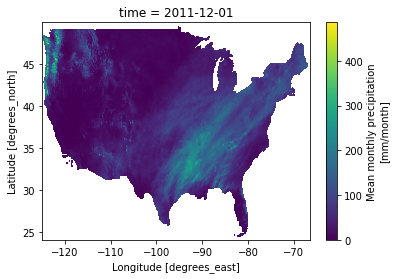

In [17]:
import matplotlib.pyplot as plt
timestep.plot()

### Using a local STAC catalog
This just shows how the conversion from STAC to Dask object works, when the file being remote doesn't get in the way

In [18]:
local_cat = StacCatalog('catalog.json')
list(local_cat)

['test_netcdf']

In [19]:
item = local_cat['test_netcdf']['test_netcdf']

In [20]:
dask_item = item.to_dask()
dask_item

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 21, time: 101)
Dimensions without coordinates: lat, lon, time
Data variables:
    ppt      (time, lat, lon) float64 dask.array<shape=(101, 21, 21), chunksize=(101, 21, 21)>
Attributes:
    _NCProperties:             version=1|netcdflibversion=4.4.1|hdf5libversio...
    Conventions:               CF-1.4
    acknowledgment:            PRISM Climate Group, Oregon State University, ...
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Parameter-elevation Regressions on Independent...
    summary:                    This dataset was created using the PRISM (Par...
    keywords:                  Atmospheric Temperature, Air Temperature Atmos...
    keywords_vocabulary:       GCMD Science Keywords
    id:                        prism/thredds/cida.usgs.gov
    naming_authority:          cida.usgs.gov|owi.usgs.gov
    cdm_data_type:             Grid
    creator_name:              Christopher Daley
    creato

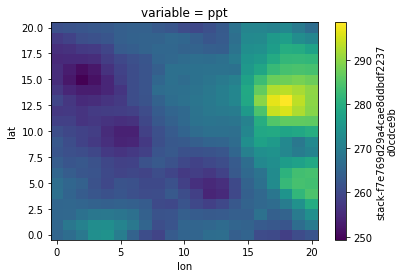

In [21]:
local_timestep = dask_item.isel(time=11).to_array()
local_timestep.plot()